In [1]:
from google.colab import files
files.upload()  # Step 2: Upload kaggle.json

!pip install kaggle  # Step 3: Install Kaggle API

!mkdir -p ~/.kaggle  # Step 3: Create .kaggle directory
!mv kaggle.json ~/.kaggle/  # Step 3: Move kaggle.json to .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Step 3: Set permissions

!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models  # Step 4: Download dataset

!unzip cats-faces-64x64-for-generative-models.zip  # Step 5: Unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
project_name = 'CAT-dcgan'

In [4]:
# DATA_DIR = '../input/cats-faces-64x64-for-generative-models/'

In [5]:
# print(os.listdir(DATA_DIR))

In [6]:
# print(os.listdir(DATA_DIR+'/cats')[:10])
print(os.listdir('/content/cats')[:10])

['12332.jpg', '8119.jpg', '7435.jpg', '7954.jpg', '2297.jpg', '4992.jpg', '14647.jpg', '9954.jpg', '12715.jpg', '6940.jpg']


In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder('/content/cats', transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

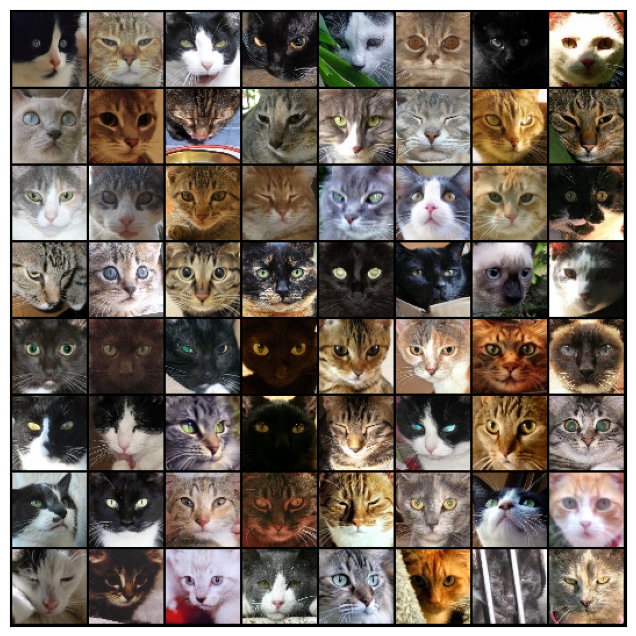

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    # nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(512),
    # nn.LeakyReLU(0.2, inplace=True),
    # # out: 512 x 4 x 4

    # nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # # out: 1 x 1 x 1

    nn.Conv2d(256, 1, kernel_size=8, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [18]:
discriminator = to_device(discriminator, device)

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    # nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(64),
    # nn.ReLU(True),
    # # out: 64 x 32 x 32

    # nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.Tanh()
    # # out: 3 x 64 x 64

    nn.ConvTranspose2d(128, 3, kernel_size=8, stride=4, padding=2, bias=False),
    nn.Tanh()
    out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


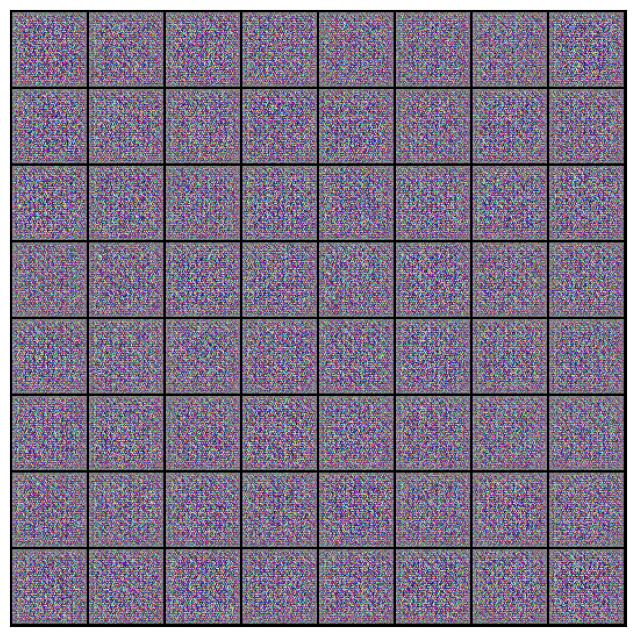

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [22]:
generator = to_device(generator, device)

In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


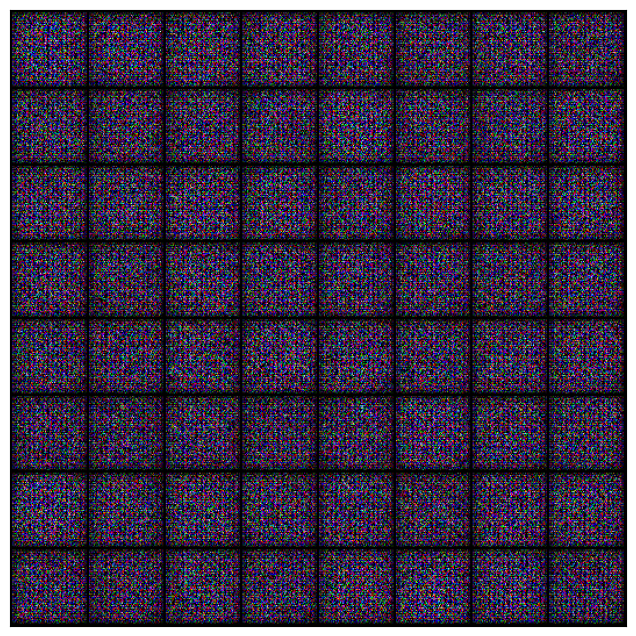

In [28]:
save_samples(0, fixed_latent)

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 60

In [31]:
history = fit(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 5.9239, loss_d: 0.0688, real_score: 0.9609, fake_score: 0.0281
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 1.0405, loss_d: 0.9810, real_score: 0.5830, fake_score: 0.0784
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 2.9599, loss_d: 0.3993, real_score: 0.8701, fake_score: 0.2188
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 6.9957, loss_d: 0.6347, real_score: 0.9640, fake_score: 0.4190
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 3.9245, loss_d: 0.1296, real_score: 0.9319, fake_score: 0.0529
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 5.0078, loss_d: 2.3677, real_score: 0.1861, fake_score: 0.0005
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 6.1295, loss_d: 0.3445, real_score: 0.9755, fake_score: 0.2624
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 3.1234, loss_d: 0.3044, real_score: 0.7999, fake_score: 0.0636
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 1.5377, loss_d: 0.7920, real_score: 0.6074, fake_score: 0.1179
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 4.2936, loss_d: 0.2152, real_score: 0.8901, fake_score: 0.0857
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 5.0906, loss_d: 0.3293, real_score: 0.9928, fake_score: 0.2109
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 1.9523, loss_d: 0.3856, real_score: 0.7687, fake_score: 0.0904
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 0.0440, loss_d: 3.2101, real_score: 0.1514, fake_score: 0.0019
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 3.7235, loss_d: 0.4058, real_score: 0.7674, fake_score: 0.0436
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 2.0938, loss_d: 0.2036, real_score: 0.8551, fake_score: 0.0304
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 3.1619, loss_d: 0.2616, real_score: 0.8416, fake_score: 0.0709
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.6789, loss_d: 0.1337, real_score: 0.9965, fake_score: 0.1141
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 2.3186, loss_d: 0.2750, real_score: 0.8156, fake_score: 0.0498
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 9.5289, loss_d: 0.7011, real_score: 0.9989, fake_score: 0.4346
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 3.9915, loss_d: 0.1107, real_score: 0.9618, fake_score: 0.0671
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 4.3280, loss_d: 0.2210, real_score: 0.9187, fake_score: 0.1153
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.0690, loss_d: 0.0753, real_score: 0.9797, fake_score: 0.0513
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 2.3541, loss_d: 0.2396, real_score: 0.8053, fake_score: 0.0130
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 5.7231, loss_d: 0.0220, real_score: 0.9955, fake_score: 0.0171
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 4.9421, loss_d: 0.0467, real_score: 0.9744, fake_score: 0.0201
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 5.2345, loss_d: 0.0248, real_score: 0.9947, fake_score: 0.0188
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 4.7750, loss_d: 0.2109, real_score: 0.8629, fake_score: 0.0387
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 4.2354, loss_d: 0.0848, real_score: 0.9306, fake_score: 0.0074
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 1.2549, loss_d: 0.4037, real_score: 0.7205, fake_score: 0.0381
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 5.3492, loss_d: 0.0945, real_score: 0.9251, fake_score: 0.0123
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 4.2211, loss_d: 0.1578, real_score: 0.9091, fake_score: 0.0522
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 5.0849, loss_d: 0.0468, real_score: 0.9799, fake_score: 0.0252
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 3.7927, loss_d: 0.1528, real_score: 0.8820, fake_score: 0.0228
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 3.2649, loss_d: 0.3522, real_score: 0.7507, fake_score: 0.0328
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 2.3981, loss_d: 0.4664, real_score: 0.7558, fake_score: 0.1368
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 5.0825, loss_d: 0.1187, real_score: 0.9964, fake_score: 0.1041
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 2.4015, loss_d: 0.3374, real_score: 0.7890, fake_score: 0.0843
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 7.2793, loss_d: 0.1821, real_score: 0.8490, fake_score: 0.0074
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 4.4049, loss_d: 0.1298, real_score: 0.9928, fake_score: 0.0966
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 2.7882, loss_d: 0.3410, real_score: 0.7820, fake_score: 0.0712
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 5.0351, loss_d: 0.1552, real_score: 0.8630, fake_score: 0.0027
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 3.3566, loss_d: 0.0691, real_score: 0.9931, fake_score: 0.0591
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 1.0274, loss_d: 1.3465, real_score: 0.3999, fake_score: 0.0099
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 4.4383, loss_d: 0.1682, real_score: 0.9199, fake_score: 0.0729
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 9.1447, loss_d: 2.7032, real_score: 0.1598, fake_score: 0.0000
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 6.6776, loss_d: 0.2460, real_score: 0.9944, fake_score: 0.1961
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 2.4364, loss_d: 3.3541, real_score: 0.2396, fake_score: 0.0018
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 11.4184, loss_d: 0.0684, real_score: 0.9346, fake_score: 0.0003
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 5.8753, loss_d: 0.0472, real_score: 0.9648, fake_score: 0.0112
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 3.7871, loss_d: 0.3951, real_score: 0.7147, fake_score: 0.0038
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 4.8436, loss_d: 0.1288, real_score: 0.9823, fake_score: 0.1004
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 7.8758, loss_d: 0.9710, real_score: 0.9738, fake_score: 0.4857
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 5.6937, loss_d: 0.1809, real_score: 0.8470, fake_score: 0.0025
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 7.0021, loss_d: 0.0691, real_score: 0.9368, fake_score: 0.0007
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 3.4987, loss_d: 0.1343, real_score: 0.9735, fake_score: 0.0981
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 6.2175, loss_d: 0.0734, real_score: 0.9422, fake_score: 0.0113
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 4.4720, loss_d: 1.4496, real_score: 0.4099, fake_score: 0.0062
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.3781, loss_d: 0.0206, real_score: 0.9987, fake_score: 0.0189
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 5.4109, loss_d: 0.2457, real_score: 0.7826, fake_score: 0.0002
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 6.0216, loss_d: 0.0812, real_score: 0.9364, fake_score: 0.0148
Saving generated-images-0060.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = history

In [33]:
from IPython.display import Image

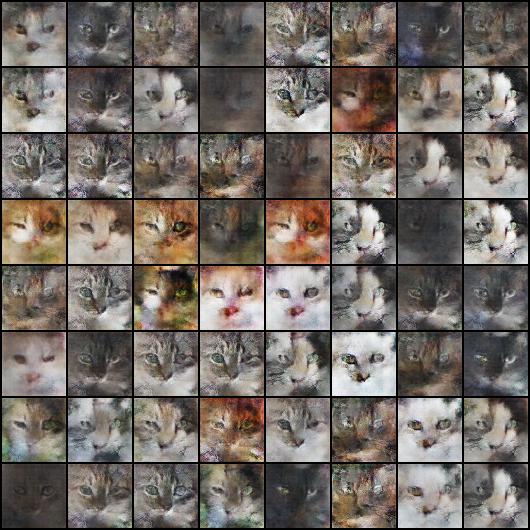

In [34]:
Image('./generated/generated-images-0060.png')

In [35]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

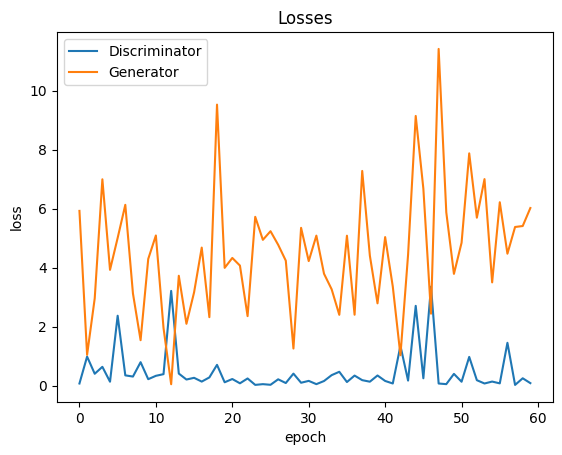

In [36]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

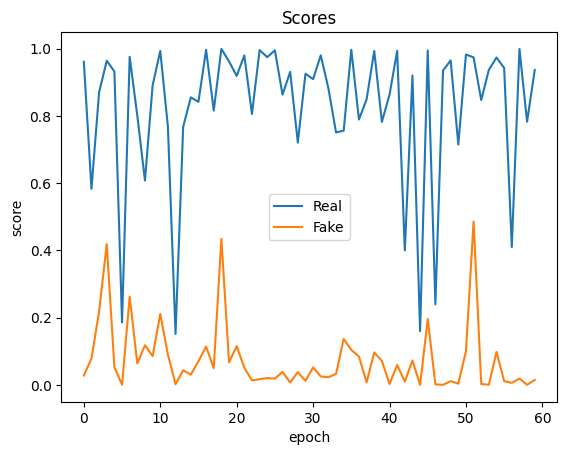

In [37]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');